# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 509 kB 20.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 20.6 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 147 kB 21.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 54 kB 3.5 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secret']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secret']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp26 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [10]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [11]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5245782,-77.6333489,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [12]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Thu Nov 19 15:02:18 +0000 2020'
'Thu Nov 19 15:02:17 +0000 2020'
'Thu Nov 19 15:02:16 +0000 2020'
'Thu Nov 19 15:02:12 +0000 2020'
'Thu Nov 19 15:02:11 +0000 2020'
'Thu Nov 19 15:02:08 +0000 2020'
'Thu Nov 19 15:02:06 +0000 2020'
'Thu Nov 19 15:02:03 +0000 2020'
'Thu Nov 19 15:02:03 +0000 2020'
'Thu Nov 19 15:01:54 +0000 2020'
'Thu Nov 19 15:01:50 +0000 2020'
'Thu Nov 19 15:01:49 +0000 2020'
'Thu Nov 19 15:01:45 +0000 2020'
'Thu Nov 19 15:01:41 +0000 2020'
'Thu Nov 19 15:01:37 +0000 2020'
'Thu Nov 19 15:01:26 +0000 2020'
'Thu Nov 19 15:01:22 +0000 2020'
'Thu Nov 19 15:01:21 +0000 2020'
'Thu Nov 19 15:01:14 +0000 2020'
'Thu Nov 19 15:01:11 +0000 2020'
'Thu Nov 19 15:01:11 +0000 2020'
'Thu Nov 19 15:01:08 +0000 2020'
'Thu Nov 19 15:01:07 +0000 2020'
'Thu Nov 19 15:01:05 +0000 2020'
'Thu Nov 19 15:00:32 +0000 2020'
'Thu Nov 19 15:00:28 +0000 2020'
'Thu Nov 19 15:00:27 +0000 2020'
'Thu Nov 19 15:00:27 +0000 2020'
'Thu Nov 19 15:00:26 +0000 2020'
'Thu Nov 19 15:00:25 +0000 2020'
'Thu Nov 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [13]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Thu Nov 19 14:56:15 +0000 2020'
'Thu Nov 19 14:56:10 +0000 2020'
'Thu Nov 19 14:56:06 +0000 2020'
'Thu Nov 19 14:56:01 +0000 2020'
'Thu Nov 19 14:56:00 +0000 2020'
'Thu Nov 19 14:55:43 +0000 2020'
'Thu Nov 19 14:55:43 +0000 2020'
'Thu Nov 19 14:55:43 +0000 2020'
'Thu Nov 19 14:55:34 +0000 2020'
'Thu Nov 19 14:55:31 +0000 2020'
'Thu Nov 19 14:55:30 +0000 2020'
'Thu Nov 19 14:55:24 +0000 2020'
'Thu Nov 19 14:55:23 +0000 2020'
'Thu Nov 19 14:55:20 +0000 2020'
'Thu Nov 19 14:55:20 +0000 2020'
'Thu Nov 19 14:55:18 +0000 2020'
'Thu Nov 19 14:55:07 +0000 2020'
'Thu Nov 19 14:55:04 +0000 2020'
'Thu Nov 19 14:55:04 +0000 2020'
'Thu Nov 19 14:55:01 +0000 2020'
'Thu Nov 19 14:55:00 +0000 2020'
'Thu Nov 19 14:54:50 +0000 2020'
'Thu Nov 19 14:54:49 +0000 2020'
'Thu Nov 19 14:54:41 +0000 2020'
'Thu Nov 19 14:54:37 +0000 2020'
'Thu Nov 19 14:54:32 +0000 2020'
'Thu Nov 19 14:54:25 +0000 2020'
'Thu Nov 19 14:54:25 +0000 2020'
'Thu Nov 19 14:54:16 +0000 2020'
'Thu Nov 19 14:54:11 +0000 2020'
'Thu Nov 1

'Thu Nov 19 14:30:22 +0000 2020'
'Thu Nov 19 14:30:21 +0000 2020'
'Thu Nov 19 14:30:20 +0000 2020'
'Thu Nov 19 14:30:19 +0000 2020'
'Thu Nov 19 14:30:18 +0000 2020'
'Thu Nov 19 14:30:18 +0000 2020'
'Thu Nov 19 14:30:17 +0000 2020'
'Thu Nov 19 14:30:00 +0000 2020'
'Thu Nov 19 14:30:00 +0000 2020'
'Thu Nov 19 14:29:57 +0000 2020'
'Thu Nov 19 14:29:55 +0000 2020'
'Thu Nov 19 14:29:54 +0000 2020'
'Thu Nov 19 14:29:52 +0000 2020'
'Thu Nov 19 14:29:26 +0000 2020'
'Thu Nov 19 14:29:24 +0000 2020'
'Thu Nov 19 14:29:20 +0000 2020'
'Thu Nov 19 14:29:14 +0000 2020'
'Thu Nov 19 14:28:56 +0000 2020'
'Thu Nov 19 14:28:48 +0000 2020'
'Thu Nov 19 14:28:26 +0000 2020'
'Thu Nov 19 14:28:25 +0000 2020'
'Thu Nov 19 14:28:22 +0000 2020'
'Thu Nov 19 14:28:11 +0000 2020'
'Thu Nov 19 14:28:04 +0000 2020'
'Thu Nov 19 14:27:48 +0000 2020'
'Thu Nov 19 14:27:44 +0000 2020'
'Thu Nov 19 14:27:43 +0000 2020'
'Thu Nov 19 14:27:42 +0000 2020'
'Thu Nov 19 14:27:41 +0000 2020'
'Thu Nov 19 14:27:39 +0000 2020'
'Thu Nov 1

'Thu Nov 19 14:06:18 +0000 2020'
'Thu Nov 19 14:06:14 +0000 2020'
'Thu Nov 19 14:06:13 +0000 2020'
'Thu Nov 19 14:06:07 +0000 2020'
'Thu Nov 19 14:06:06 +0000 2020'
'Thu Nov 19 14:06:00 +0000 2020'
'Thu Nov 19 14:05:58 +0000 2020'
'Thu Nov 19 14:05:58 +0000 2020'
'Thu Nov 19 14:05:39 +0000 2020'
'Thu Nov 19 14:05:12 +0000 2020'
'Thu Nov 19 14:05:12 +0000 2020'
'Thu Nov 19 14:05:06 +0000 2020'
'Thu Nov 19 14:05:04 +0000 2020'
'Thu Nov 19 14:05:04 +0000 2020'
'Thu Nov 19 14:05:03 +0000 2020'
'Thu Nov 19 14:05:02 +0000 2020'
'Thu Nov 19 14:04:48 +0000 2020'
'Thu Nov 19 14:04:41 +0000 2020'
'Thu Nov 19 14:04:11 +0000 2020'
'Thu Nov 19 14:03:57 +0000 2020'
'Thu Nov 19 14:03:56 +0000 2020'
'Thu Nov 19 14:03:54 +0000 2020'
'Thu Nov 19 14:03:53 +0000 2020'
'Thu Nov 19 14:03:52 +0000 2020'
'Thu Nov 19 14:03:51 +0000 2020'
'Thu Nov 19 14:03:38 +0000 2020'
'Thu Nov 19 14:03:38 +0000 2020'
'Thu Nov 19 14:03:38 +0000 2020'
'Thu Nov 19 14:03:29 +0000 2020'
'Thu Nov 19 14:03:24 +0000 2020'
'Thu Nov 1

'Thu Nov 19 13:38:01 +0000 2020'
'Thu Nov 19 13:37:56 +0000 2020'
'Thu Nov 19 13:37:52 +0000 2020'
'Thu Nov 19 13:37:43 +0000 2020'
'Thu Nov 19 13:37:25 +0000 2020'
'Thu Nov 19 13:37:16 +0000 2020'
'Thu Nov 19 13:36:53 +0000 2020'
'Thu Nov 19 13:36:34 +0000 2020'
'Thu Nov 19 13:36:32 +0000 2020'
'Thu Nov 19 13:36:27 +0000 2020'
'Thu Nov 19 13:36:25 +0000 2020'
'Thu Nov 19 13:36:25 +0000 2020'
'Thu Nov 19 13:36:20 +0000 2020'
'Thu Nov 19 13:35:44 +0000 2020'
'Thu Nov 19 13:35:28 +0000 2020'
'Thu Nov 19 13:35:25 +0000 2020'
'Thu Nov 19 13:35:12 +0000 2020'
'Thu Nov 19 13:35:11 +0000 2020'
'Thu Nov 19 13:34:55 +0000 2020'
'Thu Nov 19 13:34:53 +0000 2020'
'Thu Nov 19 13:34:53 +0000 2020'
'Thu Nov 19 13:34:53 +0000 2020'
'Thu Nov 19 13:34:45 +0000 2020'
'Thu Nov 19 13:34:39 +0000 2020'
'Thu Nov 19 13:34:34 +0000 2020'
'Thu Nov 19 13:34:33 +0000 2020'
'Thu Nov 19 13:34:23 +0000 2020'
'Thu Nov 19 13:34:04 +0000 2020'
'Thu Nov 19 13:34:03 +0000 2020'
'Thu Nov 19 13:33:56 +0000 2020'
'Thu Nov 1

'Thu Nov 19 13:06:45 +0000 2020'
'Thu Nov 19 13:06:36 +0000 2020'
'Thu Nov 19 13:06:28 +0000 2020'
'Thu Nov 19 13:06:17 +0000 2020'
'Thu Nov 19 13:06:16 +0000 2020'
'Thu Nov 19 13:06:15 +0000 2020'
'Thu Nov 19 13:06:07 +0000 2020'
'Thu Nov 19 13:06:04 +0000 2020'
'Thu Nov 19 13:05:40 +0000 2020'
'Thu Nov 19 13:05:38 +0000 2020'
'Thu Nov 19 13:05:36 +0000 2020'
'Thu Nov 19 13:05:35 +0000 2020'
'Thu Nov 19 13:05:34 +0000 2020'
'Thu Nov 19 13:05:25 +0000 2020'
'Thu Nov 19 13:05:23 +0000 2020'
'Thu Nov 19 13:05:12 +0000 2020'
'Thu Nov 19 13:05:09 +0000 2020'
'Thu Nov 19 13:05:07 +0000 2020'
'Thu Nov 19 13:05:06 +0000 2020'
'Thu Nov 19 13:05:06 +0000 2020'
'Thu Nov 19 13:05:04 +0000 2020'
'Thu Nov 19 13:04:51 +0000 2020'
'Thu Nov 19 13:04:46 +0000 2020'
'Thu Nov 19 13:04:42 +0000 2020'
'Thu Nov 19 13:04:41 +0000 2020'
'Thu Nov 19 13:04:37 +0000 2020'
'Thu Nov 19 13:04:36 +0000 2020'
'Thu Nov 19 13:04:36 +0000 2020'
'Thu Nov 19 13:04:33 +0000 2020'
'Thu Nov 19 13:04:31 +0000 2020'
'Thu Nov 1

'Thu Nov 19 12:51:11 +0000 2020'
'Thu Nov 19 12:51:10 +0000 2020'
'Thu Nov 19 12:51:04 +0000 2020'
'Thu Nov 19 12:51:04 +0000 2020'
'Thu Nov 19 12:51:02 +0000 2020'
'Thu Nov 19 12:51:00 +0000 2020'
'Thu Nov 19 12:50:56 +0000 2020'
'Thu Nov 19 12:50:53 +0000 2020'
'Thu Nov 19 12:50:48 +0000 2020'
'Thu Nov 19 12:50:45 +0000 2020'
'Thu Nov 19 12:50:45 +0000 2020'
'Thu Nov 19 12:50:44 +0000 2020'
'Thu Nov 19 12:50:44 +0000 2020'
'Thu Nov 19 12:50:42 +0000 2020'
'Thu Nov 19 12:50:36 +0000 2020'
'Thu Nov 19 12:50:34 +0000 2020'
'Thu Nov 19 12:50:33 +0000 2020'
'Thu Nov 19 12:50:32 +0000 2020'
'Thu Nov 19 12:50:30 +0000 2020'
'Thu Nov 19 12:50:30 +0000 2020'
'Thu Nov 19 12:50:25 +0000 2020'
'Thu Nov 19 12:50:24 +0000 2020'
'Thu Nov 19 12:50:23 +0000 2020'
'Thu Nov 19 12:50:21 +0000 2020'
'Thu Nov 19 12:50:19 +0000 2020'
'Thu Nov 19 12:50:18 +0000 2020'
'Thu Nov 19 12:50:15 +0000 2020'
'Thu Nov 19 12:50:14 +0000 2020'
'Thu Nov 19 12:50:14 +0000 2020'
'Thu Nov 19 12:50:13 +0000 2020'
'Thu Nov 1

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [14]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

1515
1367


Create a text index and print the Tweets containing specific keywords. 

In [15]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [16]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [17]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Derek Johnson
text: @Bobbyray1971 @realDonaldTrump From #COVID19.
----
name: Trump Mentions
text: RT @derekjGZ: @Bobbyray1971 @realDonaldTrump From #COVID19.
----
name: Erin Snider🆘️ 🇺🇸 🦋🌍🌊
text: #COVID19 truth. https://t.co/OiHGHlRUvv
----
name: Sean Newboy
text: RT @AdaKirschner: Advice from the frontline.

#COVID19 #coronavirus
----
name: Erin Snider🆘️ 🇺🇸 🦋🌍🌊
text: #TrumpOwnsEveryDeath #COVID19 https://t.co/T5HvdIlkXD
----
name: Erin Snider🆘️ 🇺🇸 🦋🌍🌊
text: @magicduster If his mouth is open,  he's lying.  #TrumpLiesPeopleDie #COVID19 ☠
----
name: Erin Snider🆘️ 🇺🇸 🦋🌍🌊
text: #COVID19 reality. 😦 https://t.co/ibF6CeFV3l
----
name: Walter Lochner
text: RT @dcbat: Does #DonaldTrump deserve credit for any #COVID19 #vaccines?
----
name: Sevda.Ayla
text: #Azerbaijan #COVID19 #BeSafe https://t.co/8vUZrZYNZE
----
name: Everet Marsh
text: RT @dcbat: Does #DonaldTrump deserve credit for any #COVID19 #vaccines?


In [18]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [19]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,possibly_sensitive,extended_entities
0,5fb6895e0b36b3e710a3365c,Thu Nov 19 12:54:59 +0000 2020,1329407825982992384,1329407825982992384,@Bobbyray1971 @realDonaldTrump From #COVID19.,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.329406e+18,...,4,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,5fb6895e0b36b3e710a33656,Thu Nov 19 12:55:07 +0000 2020,1329407857561841666,1329407857561841666,RT @derekjGZ: @Bobbyray1971 @realDonaldTrump F...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://twitter.com/DJTMentionsBot"" r...",NaN,...,0,False,False,en,{'created_at': 'Thu Nov 19 12:54:59 +0000 2020...,NaN,NaN,NaN,NaN,NaN
2,5fb6895c0b36b3e710a335b9,Thu Nov 19 13:06:15 +0000 2020,1329410659700785153,1329410659700785153,#COVID19 truth. https://t.co/OiHGHlRUvv,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,NaN,1.328831e+18,1328830561574674434,{'created_at': 'Tue Nov 17 22:41:09 +0000 2020...,False,NaN
3,5fb6894f0b36b3e710a331c0,Thu Nov 19 14:51:42 +0000 2020,1329437200098996226,1329437200098996226,RT @AdaKirschner: Advice from the frontline.\n...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,{'created_at': 'Thu Nov 19 14:44:23 +0000 2020...,1.329427e+18,1329426914440777729,NaN,NaN,NaN
4,5fb6894f0b36b3e710a3318d,Thu Nov 19 14:55:20 +0000 2020,1329438114377588736,1329438114377588736,#TrumpOwnsEveryDeath #COVID19 https://t.co/T5H...,False,"{'hashtags': [{'text': 'TrumpOwnsEveryDeath', ...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,und,NaN,1.324400e+18,1324399643049009154,{'created_at': 'Thu Nov 05 17:14:15 +0000 2020...,False,NaN
5,5fb689020b36b3e710a3317a,Thu Nov 19 14:56:28 +0000 2020,1329438397774123012,1329438397774123012,"@magicduster If his mouth is open, he's lying...",False,"{'hashtags': [{'text': 'TrumpLiesPeopleDie', '...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.329429e+18,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
6,5fb6895e0b36b3e710a3365e,Thu Nov 19 12:54:54 +0000 2020,1329407806793945088,1329407806793945088,#COVID19 reality. 😦 https://t.co/ibF6CeFV3l,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,en,NaN,1.329214e+18,1329214189819203584,{'created_at': 'Thu Nov 19 00:05:33 +0000 2020...,False,NaN
7,5fb689570b36b3e710a3343f,Thu Nov 19 13:49:34 +0000 2020,1329421561686704134,1329421561686704134,RT @dcbat: Does #DonaldTrump deserve credit fo...,False,"{'hashtags': [{'text': 'DonaldTrump', 'indices...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,...,0,False,False,en,{'created_at': 'Thu Nov 19 01:19:04 +0000 2020...,NaN,NaN,NaN,NaN,NaN
8,5fb689570b36b3e710a33411,Thu Nov 19 13:55:50 +0000 2020,1329423137977622530,1329423137977622530,#Azerbaijan #COVID19 #BeSafe https://t.co/8vUZ...,False,"{'hashtags': [{'text': 'Azerbaijan', 'indices'...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,und,NaN,1.329343e+18,1329342864489394176,{'created_at': 'Thu Nov 19 08:36:51 +0000 2020...,False,NaN
9,5fb689570b36b3e710a3340e,Thu Nov 19 13:55:55 +0000 

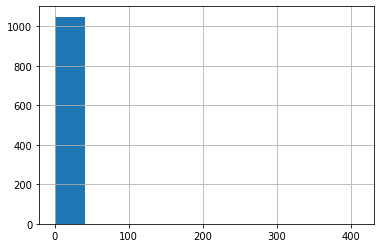

In [20]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count